In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KernelDensity
import numpy as np
from numpy import array, linspace
from scipy.signal import argrelextrema
from sklearn.cross_validation import LeaveOneOut
import jenkspy
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.io import output_file, output_notebook, show, curdoc
from bokeh.plotting import figure
from bokeh.layouts import Column, widgetbox, Row
from bokeh.palettes import Viridis256, Spectral6, Blues8, RdYlBu11 as palette, Inferno, Viridis10
from bokeh.models import Div, LogColorMapper, LogTicker, ColorBar, BasicTicker, Slider, Select, TextInput, DataTable, TableColumn, ColumnDataSource, CDSView, CustomJS, ContinuousColorMapper, LinearColorMapper, ColumnDataSource, GeoJSONDataSource, CategoricalColorMapper, LogColorMapper, HoverTool
from bokeh.client import push_session
import subprocess
import time

C:\Users\katep\Miniconda3\envs\cy_example\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\katep\Miniconda3\envs\cy_example\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#Setting the filepath and loading in a shapefile
file = "./files/countries.shp"
map_df = gpd.read_file(file)

#Loading the datasets & doing some data processing like column re-naming
df = pd.read_csv('./files/index.csv').dropna()
df.columns = ['rank', 'code', 'country', 'ethnic_index', 'cultural_index']

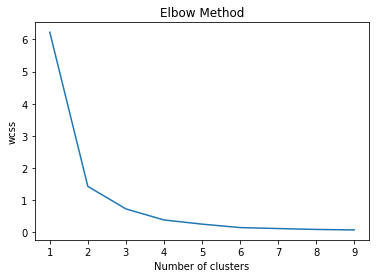

<ipython-input-13-b697ef793aff>:20: SyntaxWarning: name 'y_means' is assigned to before global declaration
  global y_means


In [13]:
#To identify natural breaks, we will used K-means clustering algorithm. K-means is a simple unsupervised machine learning algorithm that groups a dataset into a user-specified number (k) of clusters. Dropping NAs as the K-means 'doesnt tolerate' missing values.
#Although it's recommended to have between 5 and 10 categories, but we will use the elbow method to identify the number of classes
#The idea of the elbow method is to run k-means clustering on the dataset for a range of values of k (say, k from 1 to 10 in the examples above). The idea is to find the # of clusters where Within Cluster Sum of Squares is min. 
wcss = []
for i in range(1, 10):
    km = KMeans(n_clusters = i, random_state = 0)
    km.fit(df[['cultural_index']])
    wcss.append(km.inertia_)
_ = plt.plot(range(1,10), wcss)
_ = plt.title('Elbow Method')
_ = plt.xlabel('Number of clusters')
_ = plt.ylabel('wcss')
plt.show()

#Elbow at k=4 indicating 4 is the best number of clusters. Fitting kmeans to the dataset with k=4
def k_mn(x, n):
    '''The function estimates classes based on the k-means algorithm'''
    km = KMeans(n_clusters = n, random_state = 0)
    y_means = km.fit_predict(x)
    global y_means
k_mn(df[['cultural_index']], 4)
df['k_means'] = pd.Series(y_means, index = df.index)

def cl_kmeans(x):
    if x == 0:
        return 1
    elif x == 1:
        return 2
    elif x == 2:
        return 3
    elif x == 3:
        return 4
    else:
        return 'N/A'
df['k_means'] = df['k_means'].apply(cl_kmeans)

C:\Users\katep\Miniconda3\envs\cy_example\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


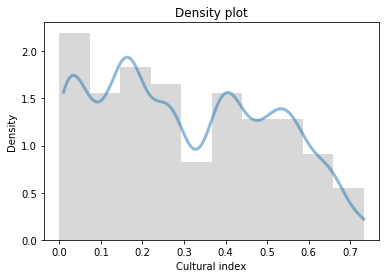

In [4]:
#Kernel density estimation
x_grid = np.linspace(0.01, df[['cultural_index']].max(), len(df))
#Finding the optimal bandwidth
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': x_grid}, cv = 20)
grid.fit(np.array(df[['cultural_index']]))
kde = grid.best_estimator_
pdf = np.exp(kde.score_samples(x_grid[:, None]))
mi, ma = argrelextrema(pdf, np.less)[0], argrelextrema(pdf, np.greater)[0]
#Ploting the density and histogram
fig, ax = plt.subplots()
_ = ax.plot(x_grid, pdf, linewidth = 3, alpha = 0.5)
_ = ax.hist(df['cultural_index'], fc = 'gray', histtype = 'stepfilled', alpha = 0.3, normed = True)
_ = plt.xlabel('Cultural index')
_ = plt.ylabel('Density')
_ = plt.title('Density plot')

def cls_kern(X):
    '''The function assigns lables depending on which interval a data point falls into'''
    for x in X:
        if x < x_grid[ma][0]: return '1'
        elif (x >= x_grid[ma][0]) * (x < x_grid[ma][1]): return '2'
        elif (x >= x_grid[ma][1]) * (x < x_grid[ma][2]): return '3'
        else: return '4'
df['kernel_den'] = df[['cultural_index']].apply(cls_kern, axis = 1)   

In [5]:
#Implementing Jenks Natural Breaks. I have used the optimum # of classes identified with the Elbow method
jnks = jenkspy.jenks_breaks(np.array(df['cultural_index']), nb_class = 4)
def cls_jenks(X):
    '''The function assigns lables depending on which interval a data point falls into'''
    for x in X:
        if x < jnks[1]: return '1'
        elif (x >= jnks[1]) * (x < jnks[2]): return '2'
        elif (x >= jnks[2]) * (x < jnks[3]): return '3'
        else: return '4'
df['nat_jenks'] = df[['cultural_index']].apply(cls_jenks, axis = 1)

In [6]:
#Finding intervals based on percentiles
prcntl = np.percentile(np.array(df['cultural_index']), [25,50,75])
def cls_prcntl(X):
    '''The function assigns lables depending on which interval a data point falls into'''
    for x in X:
        if x < prcntl[0]: return '1'
        elif (x >= prcntl[0]) * (x < prcntl[1]): return '2'
        else: return '3'
df['percnt'] = df[['cultural_index']].apply(cls_prcntl, axis = 1)

In [7]:
#Finding intervals based on the nested means classification
lst = []
lst.append(df['cultural_index'].mean())

def nested_mean(x, N):
    '''The function calculates the nested means'''
    if N == 4:    
        second_order_min = lst.append(x[x < x.mean()].mean())
        second_order_max = lst.append(x[x > x.mean()].mean())
    elif N == 6:
        second_order_min = lst.append(x[x < x.mean()].mean())
        second_order_max = lst.append(x[x > x.mean()].mean())        
        third_order_min = lst.append(x[x < (x[x < x.mean()].mean())].mean())
        third_order_max = lst.append(x[x > (x[x > x.mean()].mean())].mean())        
    lst.sort()
nested_mean(df['cultural_index'], 4)

def cls_nested(X):
    '''The function assigns lables depending on which interval a data point falls into'''
    for x in X:
        if x < lst[0]: return '1'
        elif (x >= lst[0]) * (x < lst[1]): return '2'
        elif (x >= lst[1]) * (x < lst[2]): return '3'
        else: return '4'
df['nested_mean'] = df[['cultural_index']].apply(cls_nested, axis = 1)

In [8]:
#Equal intervals method
intervals = ((df['cultural_index'].max() - df['cultural_index'].min()) / 4).round(decimals = 2)
limits = []

limits.append(df['cultural_index'].min() + intervals)
def classes(N):
    '''The function defines the lower limits'''
    n = 0
    while n < N:
        for n in range(0, N):
            limits.append(limits[n] + intervals)
            n += n                  
    return limits[:-2]  
classes (4)

def cl_equal_intevals(X):
    '''The function assigns lables depending on which interval a data point falls into'''    
    for x in X:
        if x < limits[1]: return '1'
        elif (x >= limits[1]) * (x < limits[2]): return '2'
        elif (x >= limits[2]) * (x < limits[3]): return '3'
        else: return '4'
df['eq_intervals'] = df[['cultural_index']].apply(cl_equal_intevals, axis = 1)

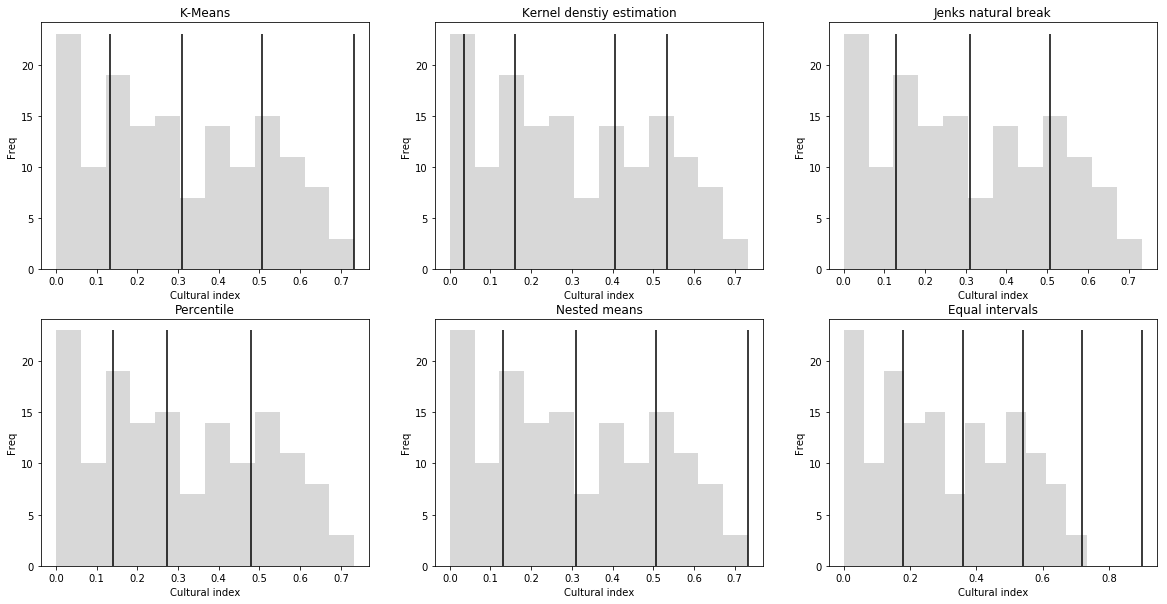

In [9]:
#Visualizing the difference
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(231)
ax = plt.hist(df['cultural_index'], bins = 12, histtype = 'stepfilled', fc = 'gray', alpha = 0.3)
_ = plt.title('K-Means')
_ = plt.xlabel('Cultural index')
_ = plt.ylabel('Freq')
lst = np.array(df.loc[:, ['cultural_index', 'k_means']].groupby('k_means').max())
for l in lst:
    plt.vlines(l, ymin = 0, ymax = max(ax[0]))
ax2 = f.add_subplot(232)
ax2 = plt.hist(df['cultural_index'], bins = 12, histtype = 'stepfilled', fc = 'gray', alpha = 0.3)
_ = plt.title('Kernel denstiy estimation')
_ = plt.xlabel('Cultural index')
_ = plt.ylabel('Freq')
for p in x_grid[ma]:
    plt.vlines(p, ymin = 0, ymax = max(ax2[0]))   
    
ax3 = f.add_subplot(233)
ax3 = plt.hist(df['cultural_index'], bins = 12, histtype = 'stepfilled', fc = 'gray', alpha = 0.3)
_ = plt.title('Jenks natural break')
_ = plt.xlabel('Cultural index')
_ = plt.ylabel('Freq')
for b in jnks[1:-1]:
    plt.vlines(b, ymin = 0, ymax = max(ax3[0]))
    
ax4 = f.add_subplot(234)
ax4 = plt.hist(df['cultural_index'], bins = 12, histtype = 'stepfilled', fc = 'gray', alpha = 0.3)
_ = plt.title('Percentile')
_ = plt.xlabel('Cultural index')
_ = plt.ylabel('Freq')
for b in prcntl:
    plt.vlines(b, ymin = 0, ymax = max(ax4[0]))
    
ax5 = f.add_subplot(235)
ax5 = plt.hist(df['cultural_index'], bins = 12, histtype = 'stepfilled', fc = 'gray', alpha = 0.3)
_ = plt.title('Nested means')
_ = plt.xlabel('Cultural index')
_ = plt.ylabel('Freq')
for p in lst:
    plt.vlines(p, ymin = 0, ymax = max(ax5[0]))
    
ax6 = f.add_subplot(236)   
ax6 = plt.hist(df['cultural_index'], bins = 12, histtype = 'stepfilled', fc = 'gray', alpha = 0.3)
_ = plt.title('Equal intervals')
_ = plt.xlabel('Cultural index')
_ = plt.ylabel('Freq')
for b in limits:
    plt.vlines(b, ymin = 0, ymax = max(ax6[0]))
plt.show()

In [12]:
#Presenting the number of observations in every class
a = df.loc[:, ['rank', 'k_means']].groupby('k_means').count().iloc[:,0]
b = df.loc[:, ['rank', 'kernel_den']].groupby('kernel_den').count().iloc[:,0]
c = df.loc[:, ['rank', 'nat_jenks']].groupby('nat_jenks').count().iloc[:,0]
d = df.loc[:, ['rank', 'percnt']].groupby('percnt').count().iloc[:,0]
e = df.loc[:, ['rank', 'nested_mean']].groupby('nested_mean').count().iloc[:,0]
f = df.loc[:, ['rank', 'eq_intervals']].groupby('eq_intervals').count().iloc[:,0]
a1 = pd.concat([a.reset_index(), b.reset_index()], axis=1)
b2 = pd.concat([c.reset_index(), d.reset_index()], axis=1)
c3 = pd.concat([e.reset_index(), f.reset_index()], axis=1)
d4 = pd.concat([a1.reset_index(), b2.reset_index()], axis=1)
e5 = pd.concat([c3.reset_index(), d4.reset_index()], axis=1)
e5.columns = ['','','nested_mean','','eq_intervals','','','','k_means','','kernel_den','','','nat_jenks','','percnt']
comparis = e5.iloc[:, [2, 4, 8, 10, 13, 15]]
comparis

,nested_mean,eq_intervals,k_means,kernel_den,nat_jenks,percnt
0,37,86,37,15,35,37.0
1,44,37,36,31,46,37.0
2,35,24,45,54,36,75.0
3,33,2,31,49,32,NaN


In [ ]:
#Potential implementation of geometric intervals
class_wdith = (x.max()/0.0001).pow(1.0/6)
inter = []
lis = []
lis.append(x.min())
for c in range(1, 7):
    inter.append(c * class_wdith)
for l in range(len(inter) - 1):
    for i in range(len(lis)):
        sth = inter[l] + lis[i]
    lis.append(sth)
lst = [0.949549, 1.899098]
lis = []
lis.append(0)
for l in range(len(lst)):
    for i in range(len(lis)):
        sth = lst[l] + lis[i]
        lis.append(sth)

In [ ]:
select_color = Select(title = "Change color codding", options = ['K-means', 'Jenks Natural Breaks', 'Percentile', 'Equal intervals', 'Nested means'])

# Merging the geo file with the csv to get the desired columns
geo_source = GeoJSONDataSource(geojson = merged_lang.to_json())
#Creating a placeholder
p = figure(title ='List of countries ranked by cultural diversity level (mouse over to see values)', 
           tools='box_zoom, reset, save', toolbar_location = 'below',
           height = 400, width = 600) 
#Drawing the map
p.patches('xs', 'ys',
         line_color = 'black', line_width = 0.5, source = geo_source)
p.axis.visible = False

layout = Row(p, select_color)
output_file('index.html')
output_notebook()
show(layout)

In [ ]:
from bokeh.io import show, output_notebook
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LogColorMapper,
    Range1d, CustomJS, Slider
)
from bokeh.palettes import Inferno256 as palette
from bokeh.plotting import figure

from bokeh.layouts import row, widgetbox

from bokeh.sampledata.us_counties import data as counties
from bokeh.sampledata.us_states import data as states
from bokeh.sampledata.unemployment import data as unemployment
import pandas as pd
import random
import bokeh.sampledata
output_notebook()
palette.reverse()


states_accumulated ={}
available_state_codes = states.keys()

for key, value in counties.items():
    state_name = value["state"].upper()
    if state_name in states.keys() and "number" not in states[state_name]:
        states[state_name]["number"] = key[0]

for key,state in states.items():
    state["code"] = key

state_list = []

for key,state in states.items():
    state_list.append(state)

unemployment_transf = []
for key,value in unemployment.items():
    unemployment_transf.append({
        "State":key[0],
        "County":key[1],
        "Value":value
    })
unemp_df = pd.DataFrame(unemployment_transf)
unemp_sum = unemp_df.groupby("State").mean()["Value"]
unemp_sum = unemp_sum.sort_index()

unemp_sum_flat = {key:value for key, value in unemp_sum.items()}

for state in state_list:
    state["value"] = unemp_sum_flat[state["number"]]
state_df = pd.DataFrame(state_list)
color_mapper = LogColorMapper(palette=palette)

state_xy = (list(state_df["lons"].values),list(state_df["lats"].values))

max_x = max([max(l) for l in state_xy[0]])
max_y = max([max(l) for l in state_xy[1]])
min_x = min([min(l) for l in state_xy[0]])
min_y = min([min(l) for l in state_xy[1]])

data=dict(
    x=state_xy[0],
    y=state_xy[1],
    name=list(state_df["name"].values),
    used = list(state_df["value"].values)
)

data['1999'] = list(state_df["value"].values)
data['2000'] = [random.randrange(0,10) for i in range(len(state_xy[0]))]
source = ColumnDataSource(data)

TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(
    title="States", tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)
p.width=450
p.height = 450
p.x_range= Range1d(-170,-60)
p.y_range = Range1d(min_y-10,max_y+10)
p.grid.grid_line_color = None

renderer = p.patches('x', 'y', source=source,
          fill_color={'field': 'used', 'transform': color_mapper},
          fill_alpha=0.7, line_color="white", line_width=0.5)


hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Name", "@name"),
    ("Unemployment rate)", "@used%"),
    ("(Long, Lat)", "($x, $y)"),
]

callback = CustomJS(args=dict(source=source,plot=p,color_mapper = color_mapper,renderer = renderer), code="""
    var data = source.data;
    var year = year.value;
    used = data['used']
    should_be = data[String(year)]
    for (i = 0; i < should_be.length; i++) {
        used[i] = should_be[i];
    } 
""")
year_slider = Slider(start=1999, end=2000, value=1999, step=1,
                    title="year", callback=callback)
callback.args["year"] = year_slider

layout = row(
    p,
    widgetbox(year_slider),
)

show(layout)